<a name="1common."></a>
## Содержание:
* [1. Описание проекта, описание данных, загрузка и импорт библиотек](#1.)
* [2. Предобработка данных](#2.)
    - [2.1. Обработка пропущенных значений](#2.1.)
    - [2.2. Доход с каждого клиента](#2.2.)
* [3. Анализ данных](#3.)
    - [3.2. Вероятность увеличения среднего чека](#3.2.)
* [4. Проверка гипотез](#4.)
* [5. Вывод](#5.)

<a name="1."><a/><br/>
    <font size ="5"><b>1. Описание проекта, описание данных, загрузка и импорт библиотек</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов

**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
*  Гб интернет-трафика: 150 рублей

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [1]:
import pandas as pd#для работы с таблицами
import matplotlib.pyplot as plt #для работы с графиками
import numpy as np#для математики
from scipy import stats as st#для проверки гипотез
import math

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
inter = pd.read_csv('/datasets/internet.csv')
mess = pd.read_csv('/datasets/messages.csv')
tar = pd.read_csv('/datasets/tariffs.csv')
us = pd.read_csv('/datasets/users.csv')

In [3]:
all_df = [calls, inter, mess, tar, us]#описание таблиц

for df in all_df:
    name =[x for x in globals() if globals()[x] is df][0] # вытаскиваем наименование датафрейма
    print('Информация о датафрейме {}\n'.format(name))
    print( df.info() )
    print()
    print('Первые 5 строк {}'.format(name))
    print( df.head(5) )
    print()
    for i in df.columns:
        print('Число пропущенных значений в столбце ', i, ' = ', df[i].isnull().sum())
    print('Число дубликатов в датафрейме {}'.format(name), df.duplicated().sum())
    print('--------------------------------------------')

Информация о датафрейме calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

Первые 5 строк calls
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

Число пропущенных значений в столбце  id  =  0
Число пропущенных значений в столбце  call_date  =  0
Число пропущенных значений в столбце  duration  =  0
Число пропущенных значений в столбце  user_id  =  0
Число дубликатов в датафрейме calls 0
--------------------------------------------
Информация о датафрейме inter

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 en

<a name="2."><a/><br/>
    <font size ="5"><b>2. Предобработка данных</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Работать с 3 таблицами по звонкам смскам и интернету неудобно. Нужно соединить в одну, предварительно сгрупировав по user_id b месяцам. 

In [4]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
mess['month'] = pd.DatetimeIndex(mess['message_date']).month
inter['month'] = pd.DatetimeIndex(inter['session_date']).month

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61fda88c88>]],
      dtype=object)

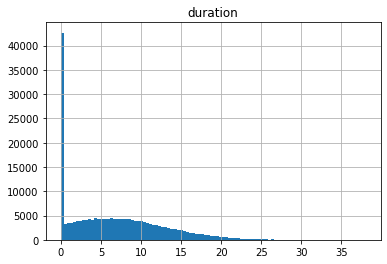

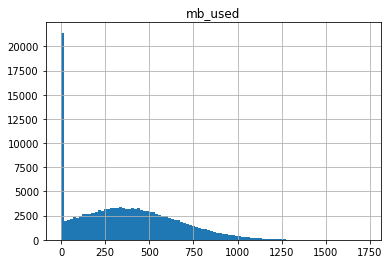

In [5]:
calls.hist('duration', bins = 100)
inter.hist('mb_used', bins = 100)

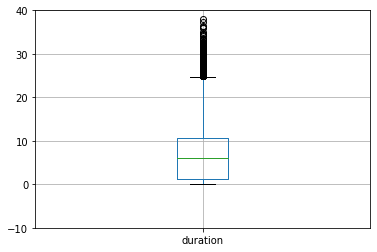

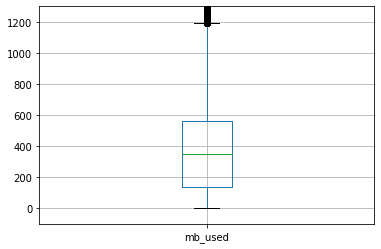

In [6]:
calls.boxplot('duration')
plt.ylim(-10,40)
plt.show()
inter.boxplot('mb_used')
plt.ylim(-100,1300)
plt.show()

**Вывод**

Распределение тяготеет к нормальному, с видимыми выбросами. Нулевые значения занимают почти 25% от данных, заменим их на среднее

<a name="2.1."><a/><br/>
    <font size ="4"><b>2.1. Обработка пропущенных значений</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [7]:
calls['duration'].value_counts()# проверяем значения по звонкам
inter['mb_used'].value_counts()# проверям значения по мб
calls['duration'].describe() #средняя и медиана почти одинаковы, заменим на средне = 6.70
inter['mb_used'].describe()#средняя и медиана почти одинаковы, заменим на медиану = 415.00
calls['duration'] = calls['duration'].replace(0.00, calls['duration'].median())
inter['mb_used'] = inter['mb_used'].replace(0.00, inter['mb_used'].median())
calls['duration'] = (calls['duration'] + 0.5).round(0)

Заменили пропущенные значения на медиану, потому что если выход или звонок зафиксированны, значит они были, вот только время не записалось

In [8]:
call = calls.pivot_table(index = ['user_id', 'month'], values = ['id', 'duration'], 
                             aggfunc = {'id': 'count','duration': 'sum'})#сгруппируем по количеству звонков и сумме минут
call.columns = ['time_call', 'calls']
mes = mess.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count')#сгруппируем по количеству смс
mes.columns = ['sms']
internet = inter.pivot_table(index = ['user_id', 'month'], values = ['id', 'mb_used'], 
                             aggfunc = {'id': 'count','mb_used': 'sum'})#сгруппируем по количеству заходов и сумме мб
internet.columns = ['enters', 'mb']

In [9]:
d = call.merge(mes, on = ['user_id', 'month'], how = 'left')
df = d.merge(internet, on = ['user_id', 'month'], how = 'left')# собрали таблицу для более удобного анализа

In [10]:
df.duplicated().sum()#дубликатов нету
df.isnull().sum()# пропущенные значения есть

time_call      0
calls          0
sms          496
enters        11
mb            11
dtype: int64

In [11]:
#заменим их на среднее
df['sms'] = df['sms'].fillna(df['sms'].mean())
df['enters'] = df['enters'].fillna(df['enters'].mean())
df['mb'] = df['mb'].fillna(df['mb'].mean())

In [12]:
print(df.isnull().sum())#отлично
df.info()#проверим типы данных. количестве смс и входах в интернет нам явно не нужент тип float

time_call    0
calls        0
sms          0
enters       0
mb           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 5 columns):
time_call    3174 non-null float64
calls        3174 non-null int64
sms          3174 non-null float64
enters       3174 non-null float64
mb           3174 non-null float64
dtypes: float64(4), int64(1)
memory usage: 137.4 KB


In [13]:
df[['sms', 'enters']] = df[['sms', 'enters']].astype(int)
df.info()#проверка, все хорошо

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 5 columns):
time_call    3174 non-null float64
calls        3174 non-null int64
sms          3174 non-null int64
enters       3174 non-null int64
mb           3174 non-null float64
dtypes: float64(2), int64(3)
memory usage: 137.4 KB


In [14]:
new_df = df.merge(us, on = ['user_id'], how = 'left')#теперь добавим пользователей
new_df1 = new_df.drop(['age', 'churn_date', 'first_name', 'last_name','reg_date'], axis=1)#удалим ненужные столбцы

In [15]:
tar.rename(columns={'tariff_name': 'tariff'}, inplace=True)#переменуем столбец для обЪединения по тарифам
new_df2 = new_df1.merge(tar, on = ['tariff'])
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 15 columns):
user_id                  3174 non-null int64
time_call                3174 non-null float64
calls                    3174 non-null int64
sms                      3174 non-null int64
enters                   3174 non-null int64
mb                       3174 non-null float64
city                     3174 non-null object
tariff                   3174 non-null object
messages_included        3174 non-null int64
mg_per_month_included    3174 non-null int64
minutes_included         3174 non-null int64
rub_monthly_fee          3174 non-null int64
rub_per_gb               3174 non-null int64
rub_per_message          3174 non-null int64
rub_per_minute           3174 non-null int64
dtypes: float64(2), int64(11), object(2)
memory usage: 396.8+ KB


<a name="2.2."><a/><br/>
    <font size ="4"><b>2.2. Доход с каждого клиента</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Посчитаем доход за каждый месяц с каждого клиента. Предварительно убрав отрицательные значения. 

In [16]:
new_df2['money_for_sms'] = (new_df2['sms'] - new_df2['messages_included']).apply(lambda x: 0 if x < 0 else x) * new_df2['rub_per_message']
new_df2['money_for_int'] = ((new_df2['mb'] - new_df2['mg_per_month_included']).apply(lambda x: 0 if x < 0 else x)) / 1000 * new_df2['rub_per_gb']
new_df2['money_for_call'] = ((new_df2['time_call'] - new_df2['minutes_included']).apply(lambda x: 0 if x < 0 else x)) * new_df2['rub_per_minute']

In [17]:
new_df2.head()#проверка

,user_id,time_call,calls,sms,enters,mb,city,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,money_for_sms,money_for_int,money_for_call
0,1000,189.0,22,22,5,2601.505,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0
1,1000,262.0,43,60,49,24973.845,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0
2,1000,376.0,47,75,29,14351.655,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0
3,1000,469.0,52,81,29,14751.960,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0
4,1000,539.0,58,57,27,15264.940,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0


<a name="3."><a/><br/>
    <font size ="5"><b>3. Анализ данных</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Посчитаем общую прибыль с каждого пользователя по месяцам.

In [18]:
new_df2['value'] = new_df2['rub_monthly_fee'] + new_df2['money_for_sms'] + new_df2['money_for_int'] + new_df2['money_for_call']
new_df2[['value','time_call','mb']] = new_df2[['value','time_call','mb']].astype(int)
new_df2.head()

,user_id,time_call,calls,sms,enters,mb,city,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,money_for_sms,money_for_int,money_for_call,value
0,1000,189,22,22,5,2601,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0,1950
1,1000,262,43,60,49,24973,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0,1950
2,1000,376,47,75,29,14351,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0,1950
3,1000,469,52,81,29,14751,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0,1950
4,1000,539,58,57,27,15264,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0.0,1950


Построим гистограммы по интересующим нас значениям

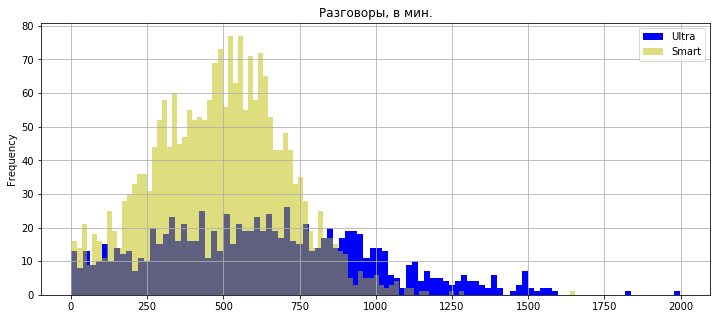

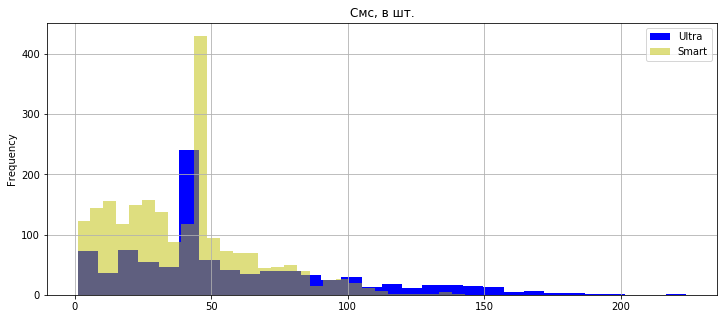

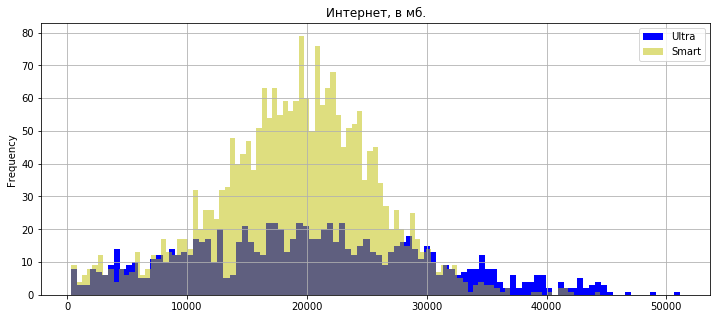

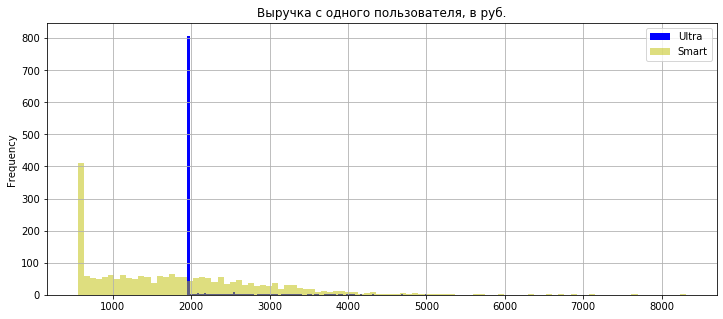

In [19]:
ultra = new_df2[new_df2['tariff'] == 'ultra']
smart = new_df2[new_df2['tariff'] == 'smart']#отфильтруем по нужным нам тарифам

ax = ultra['time_call'].plot(kind = 'hist', bins = 100, grid=True, figsize=(12, 5), color = 'b')
smart['time_call'].plot(kind = 'hist', bins = 100, grid=True, figsize=(12, 5), ax = ax, color = 'y', alpha = 0.5)
plt.legend(['Ultra', 'Smart'])
plt.title("Разговоры, в мин.")
plt.show()
ax = ultra['sms'].plot(kind = 'hist', bins = 30, grid=True, figsize=(12, 5), color = 'b')
smart['sms'].plot(kind = 'hist', bins = 30, grid=True, figsize=(12, 5), ax = ax, color = 'y', alpha = 0.5)
plt.legend(['Ultra', 'Smart'])
plt.title("Смс, в шт.")
plt.show()
ax = ultra['mb'].plot(kind = 'hist', bins = 100, grid=True, figsize=(12, 5), color = 'b')
smart['mb'].plot(kind = 'hist', bins = 100, grid=True, figsize=(12, 5), ax = ax, color = 'y', alpha = 0.5)
plt.legend(['Ultra', 'Smart'])
plt.title("Интернет, в мб.")
plt.show()
ax = ultra['value'].plot(kind = 'hist', bins = 100, grid=True, figsize=(12, 5), color = 'b')
smart['value'].plot(kind = 'hist', bins = 100, grid=True, figsize=(12, 5), ax = ax, color = 'y', alpha = 0.5)
plt.legend(['Ultra', 'Smart'])
plt.title("Выручка с одного пользователя, в руб.")
plt.show()

**Вывод:**

Запросы на интернет и смс у всех одинаковые. А вот минуты все тратят по разному. 

Распределения звонков и интернета очень похожи на нормальные.
Распределение смс - нет. 

In [20]:
#найдем среднее, стандартное отклонение и дисперсию 
a = new_df2.pivot_table(index = 'tariff', values = 'time_call', aggfunc = ['count', 'mean', 'std', 'var']).round(1)
b = new_df2.pivot_table(index = 'tariff', values = 'sms', aggfunc = ['count', 'mean', 'std', 'var']).round(1)
c = new_df2.pivot_table(index = 'tariff', values = 'mb', aggfunc = ['count', 'mean', 'std', 'var']).round(1)
d = new_df2.pivot_table(index = 'tariff', values = 'value', aggfunc = ['count', 'mean', 'std', 'var']).round(1)

In [21]:
a,b,c,d

(           count      mean       std       var
        time_call time_call time_call time_call
 tariff                                        
 smart       2223     488.6     217.6   47346.8
 ultra        951     633.7     354.8  125852.8,
        count  mean   std     var
          sms   sms   sms     sms
 tariff                          
 smart   2223  39.6  25.0   624.5
 ultra    951  58.0  40.5  1643.6,
        count     mean      std          var
           mb       mb       mb           mb
 tariff                                     
 smart   2223  18999.4   6724.5   45219285.6
 ultra    951  20293.1  10206.3  104168496.3,
        count    mean     std        var
        value   value   value      value
 tariff                                 
 smart   2223  1796.7  1108.1  1227974.3
 ultra    951  2087.7   412.6   170210.2)

<a name="3.2."><a/><br/>
    <font size ="4"><b>3.2. Вероятность увеличения среднего чека</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Распределение выручки очень не похоже на нормальное, из-за абонентской платы. Попробуем расчитать вероятность, увеличения среднего чека, используя нормальное распределение. 

Расчитаем вероятность увеличения среднего чека

In [22]:
distr_sm = st.norm(1911, 1166) 
x1 = 1911
result_sm = 1 - distr_sm.cdf(x1)
distr_ult = st.norm(2093, 422) 
x2 = 1911
result_ult = 1 - distr_ult.cdf(x2)
result_sm, result_ult

(0.5, 0.6668674667642409)

На тарифе ultra, вероятность что клиент будет приносить больше, выше на 21%

**Звонки:**

**smart** - в среднем люди не вылезают за рамки тарифа, но большое стандартное отклонение говорит нам, что половина пользователей 
все такие покупаем доп минуты

**ultra** - практически все укладываются в свои 3000 минут

**CМС:**

**smart** - похожая ситуация, как и с минутами

**ultra** - там далеко до исчерпания тарифа

**Интернет:**

**smart** - очень много людей берет дополнительный трафик

**ultra** - почти 80% укладывается в тариф

<a name="4."><a/><br/>
    <font size ="5"><b>4. Проверка гипотезы</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Сформулируем гипотезы

Нулевая - средняя выручка двух тарифов не отличается

Альтернативная - отличается


In [23]:
alpha = 0.05

results = st.ttest_ind(
    ultra['value'], 
    smart['value'])#используем гипотезу о равенстве средних двух генеральных совокупностей

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
results.pvalue

Отвергаем нулевую гипотезу


4.893821770949788e-15

Сформульруем гипотезы

Нулевая - средняя выручка Москва и других городов не отличается

Альтернативная - отличается

In [24]:
Moscow = new_df2[new_df2['city'] == 'Москва']
Other = new_df2[new_df2['city'] != 'Москва']

In [25]:
alpha = 0.05

results = st.ttest_ind(
    Moscow['value'], 
    Other['value'])#используем гипотезу о равенстве средних двух генеральных совокупностей

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
results.pvalue

Не получилось отвергнуть нулевую гипотезу


0.6087149026081973

<a name="5."><a/><br/>
    <font size ="5"><b>5. Вывод</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Тариф smart более популярный

**Среднее по выручке:**

Smart = 1857 руб/мес

Ultra = 2093 руб/мес

**Среднее по смс:**

Smart = 39 шт/мес

Ultra = 58 шт/мес

**Среднее по трафику:**

Smart = 19535 мб/мес

Ultra = 20418 мб/мес

**Среднее по минутам разговора:**

Smart = 472 мин/мес

Ultra = 612 мин/мес

Проведя анализ на статистическу значимость получили выводы:
1. Отличия выручки у двух тарифов статистически значимы, то есть они отличаются
2. Отличия выручки Москвы от регионов статистически не значимы, то есть мы не можем утверждать разные они иили нет.

**Какой тариф приносит больше выручки?**

На тарифе ultra, вероятность, что клиент будет приносить больше денег, выше на 21%